# Comparisons In A Given Loss Landscape

In [1]:
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

from minima_volume.analysis_funcs import (  grab_folder_names,
                                            load_base_train_size,
                                            list_additional_data,
                                            load_param_num,
                                            multiple_minima_fixed_landscape,
                                            fixed_landscape_minima_labels,
                                            plot_fixed_landscape_minima_pair,
                                            plot_perturb_probs,
                                            model_volume_across_targets,
                                            append_cutoff_points,
                                            varying_landscape_minima_labels,
                                            plot_minima_volume_vs_data_level,    
                                            save_results_dict_npz,
)

problem_name = "MNIST"

loss_value = 0.1  # Loss value to analyze
data_level_log = False #Is the data log distributed?
base_output_dir = "analysis"  # Root folder to save all plots
os.makedirs(base_output_dir, exist_ok=True)

# Data for the loss landscape levels
experiment_folders, data_modifications = grab_folder_names()

base_train_size = load_base_train_size(experiment_folders[0])
model_data_sizes = list_additional_data(experiment_folders[0])
num_params = load_param_num(experiment_folders[0], data_modifications[0], loss_value = loss_value)

base_shift = 0
if data_modifications[0].startswith("data_"):
    base_shift = base_train_size  # Shift to reflect true dataset size

print("Experiment folders: ", experiment_folders)
print("Different data levels where loss landscapes were computed:", data_modifications)
print("The base train size is: ", base_train_size)
print("Data levels where models were trained: ", model_data_sizes)
print("The number of model parameters is ", num_params)

First entry: Model_0, base_train_size = 60
Experiment folders:  ['model_0_data_10', 'model_1_data_11', 'model_2_data_12', 'model_3_data_13', 'model_4_data_14', 'model_5_data_15', 'model_6_data_16', 'model_7_data_17', 'model_8_data_18', 'model_9_data_19']
Different data levels where loss landscapes were computed: ['data_0', 'data_1940', 'data_19940', 'data_540', 'data_5940', 'data_59940']
The base train size is:  60
Data levels where models were trained:  [0, 1940, 19940, 540, 5940, 59940]
The number of model parameters is  235146


## Plotting Different Model Volumes In A Landscape

In [2]:
# Needed for fixed colors for background plots
import matplotlib as mpl

#cmap = mpl.colormaps.get_cmap("winter")  # blue → green
#background_colors = [cmap(i) for i in np.linspace(0, 1, 10)]

#natural_label = "Minima (On Base Dataset)"
if data_modifications[0].startswith("data_"):
    other_label = "Minima (Larger Datasets)"
else:
    other_label = "Minima (Poisoned Datasets)"


Processing data modification folder: data_0
Saved data to analysis\data_0\minima_data.npz


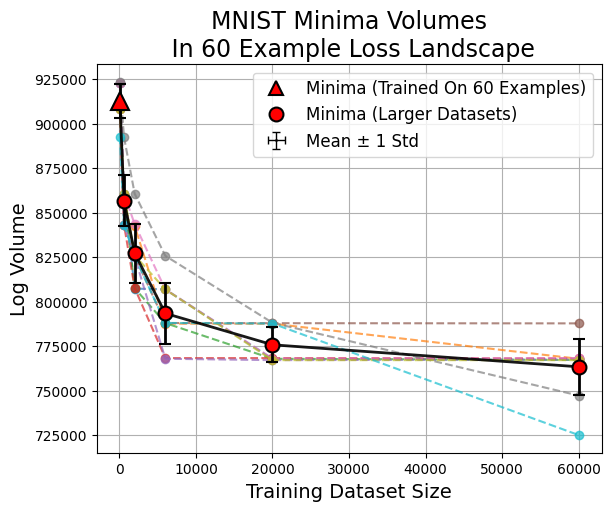

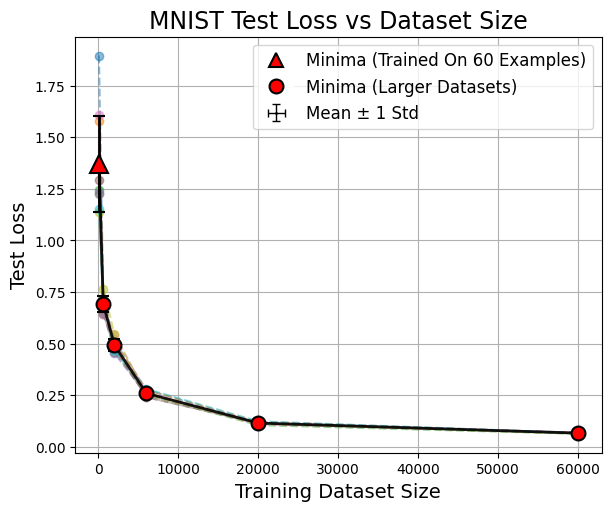

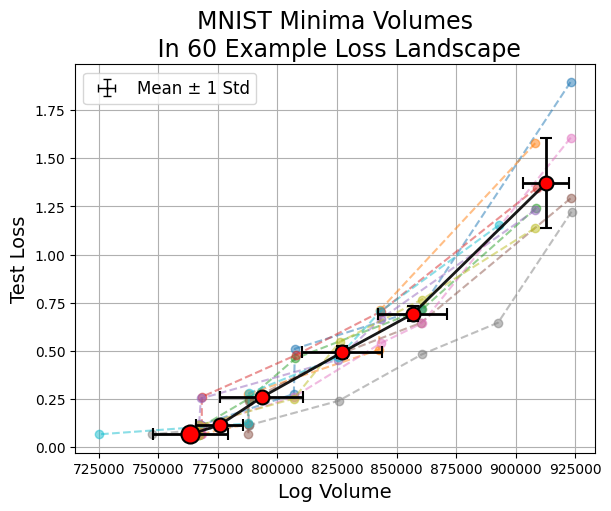

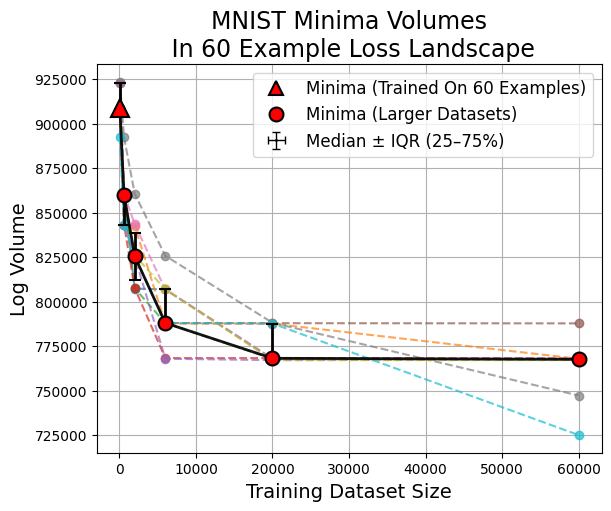

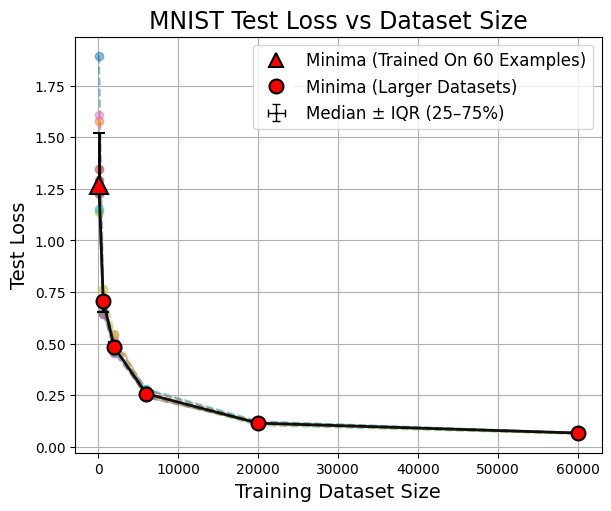

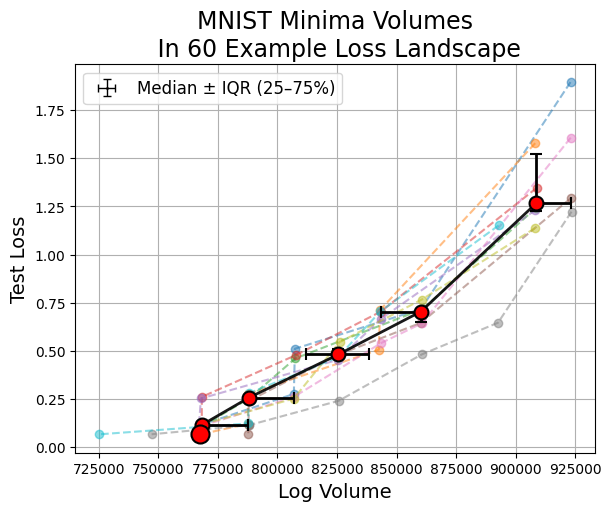


Processing data modification folder: data_1940
Saved data to analysis\data_1940\minima_data.npz


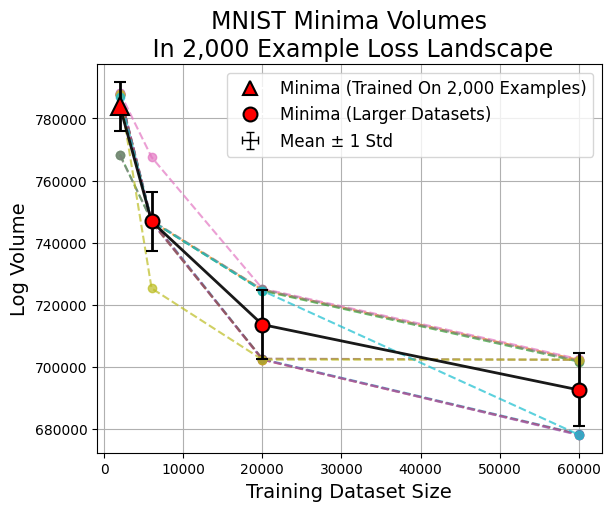

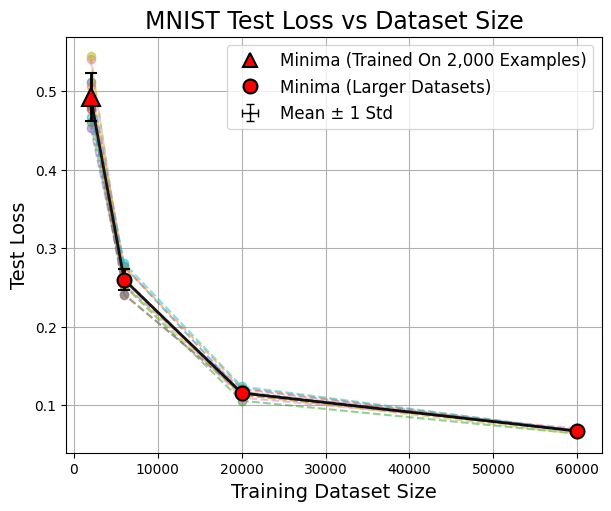

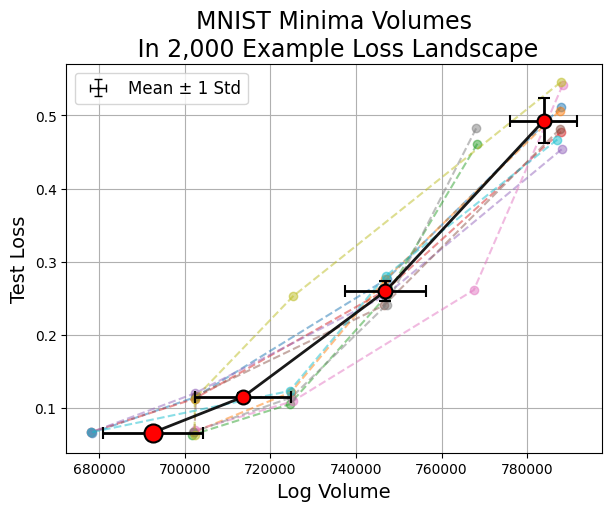

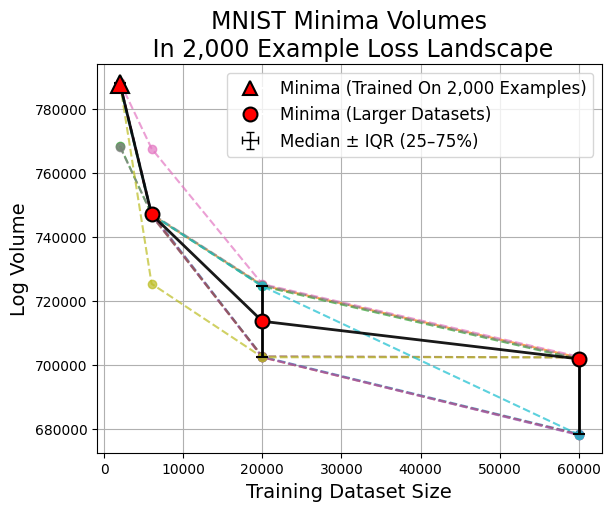

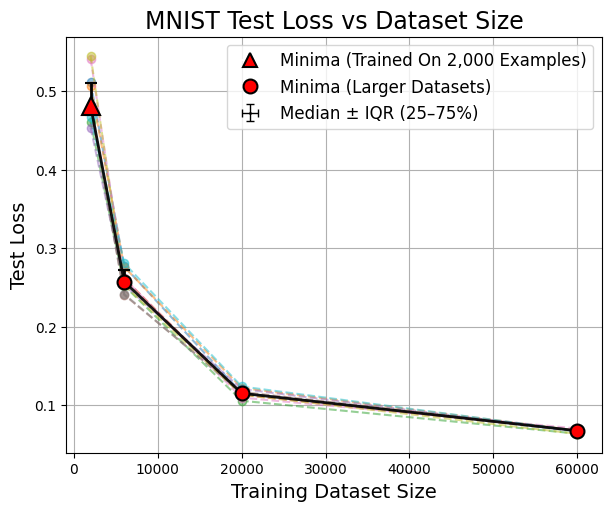

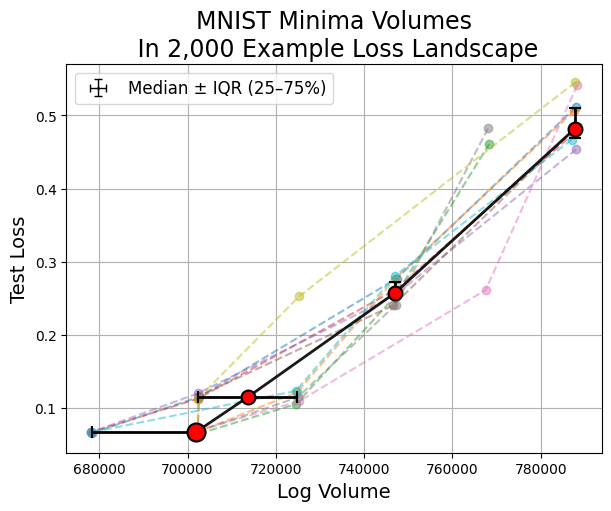


Processing data modification folder: data_19940
Saved data to analysis\data_19940\minima_data.npz


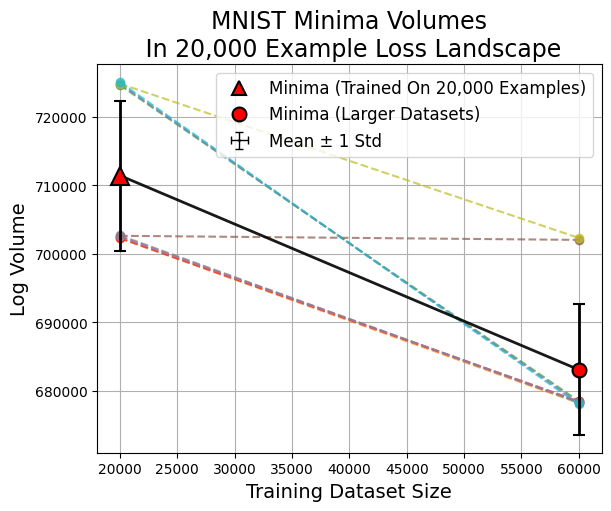

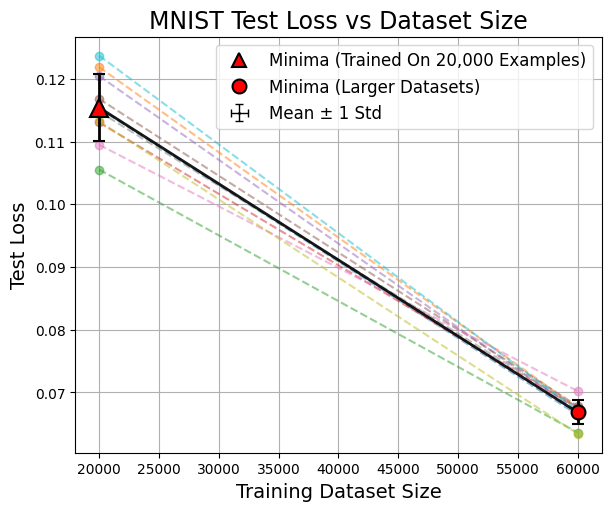

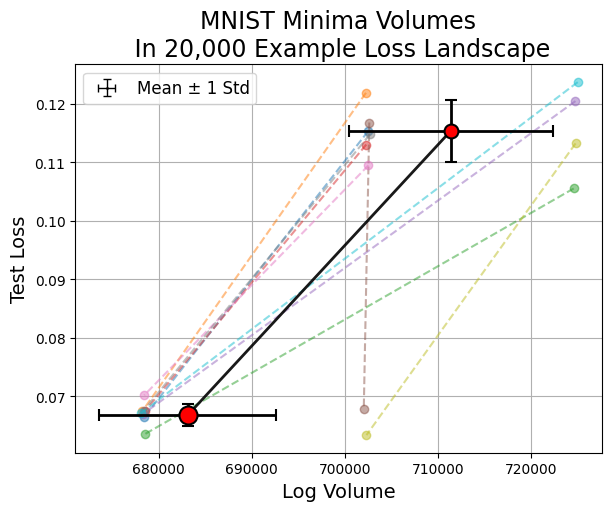

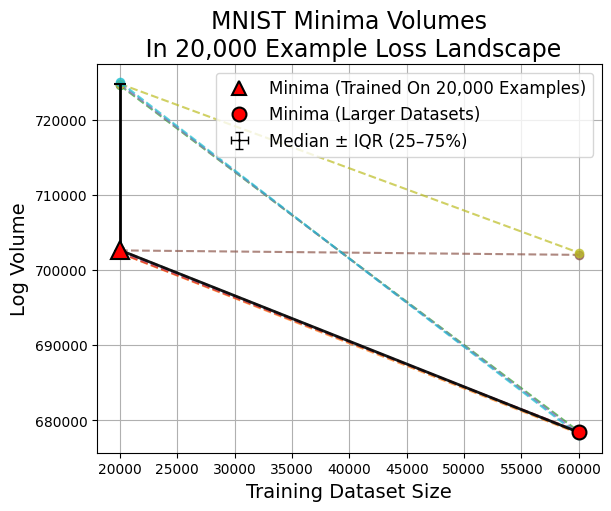

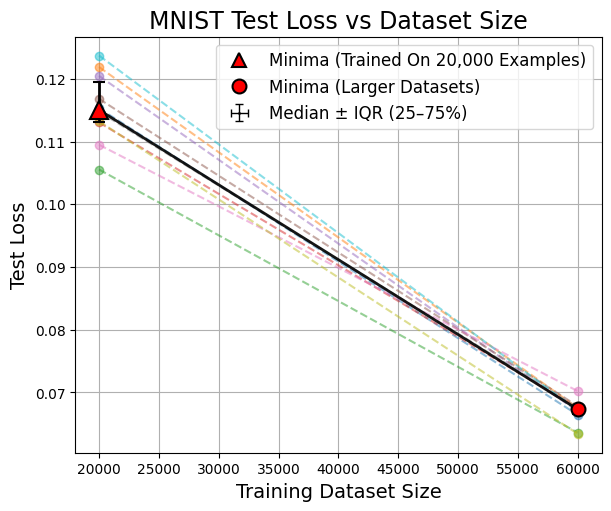

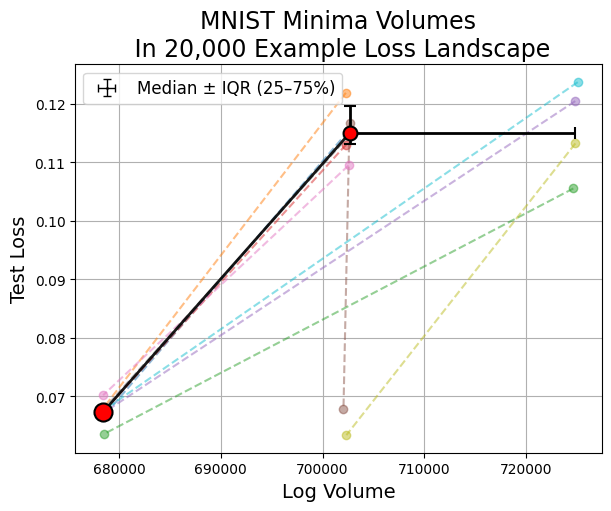


Processing data modification folder: data_540
Saved data to analysis\data_540\minima_data.npz


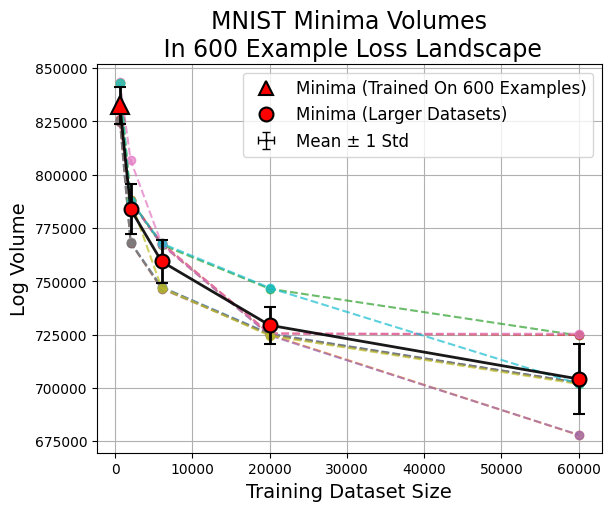

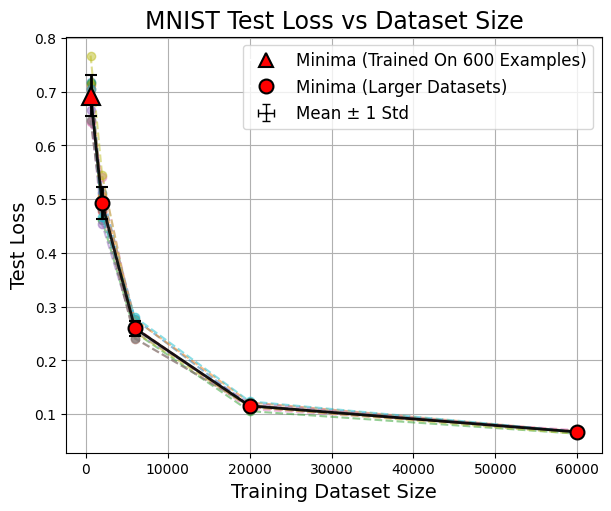

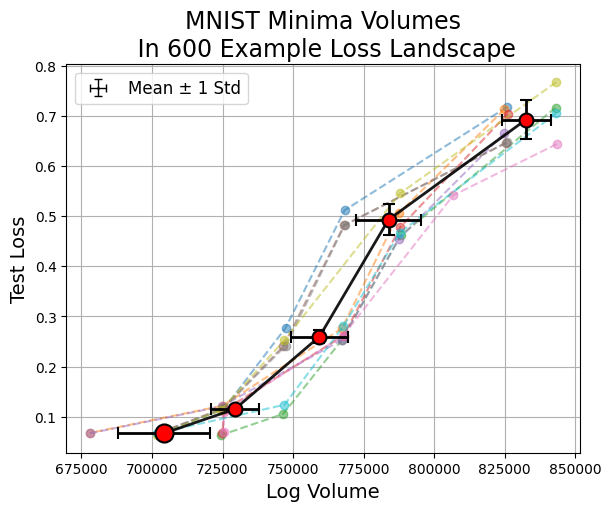

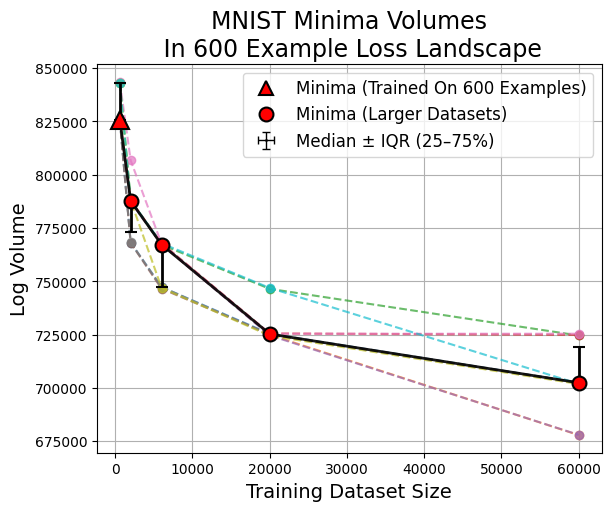

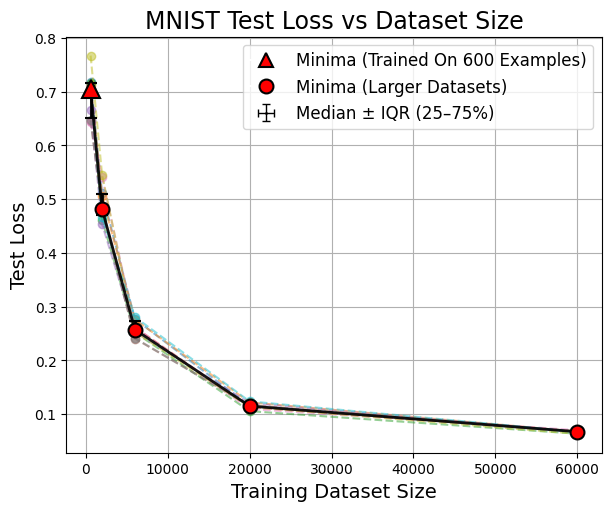

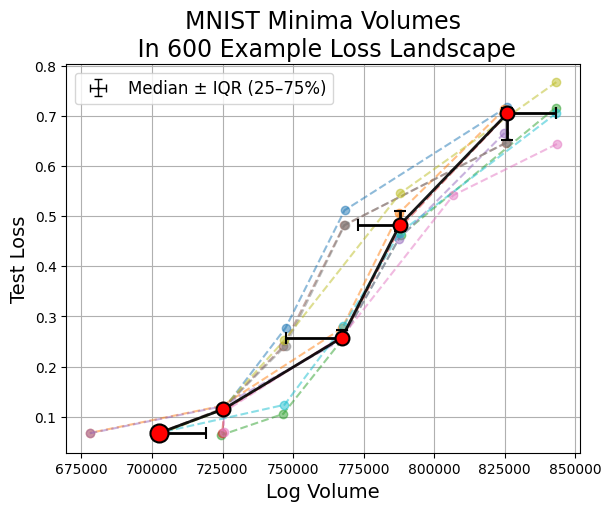


Processing data modification folder: data_5940
Saved data to analysis\data_5940\minima_data.npz


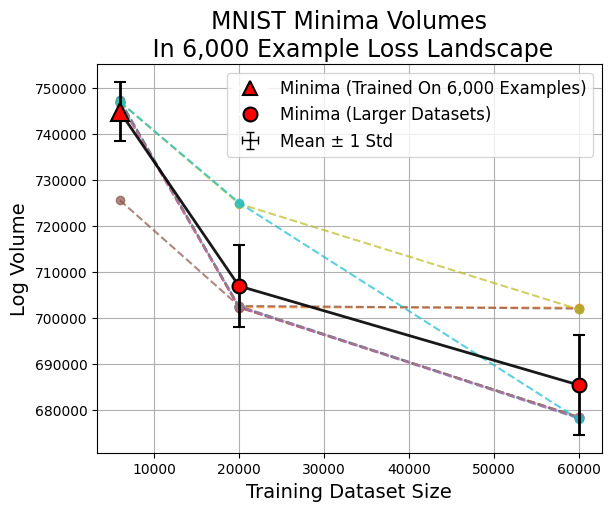

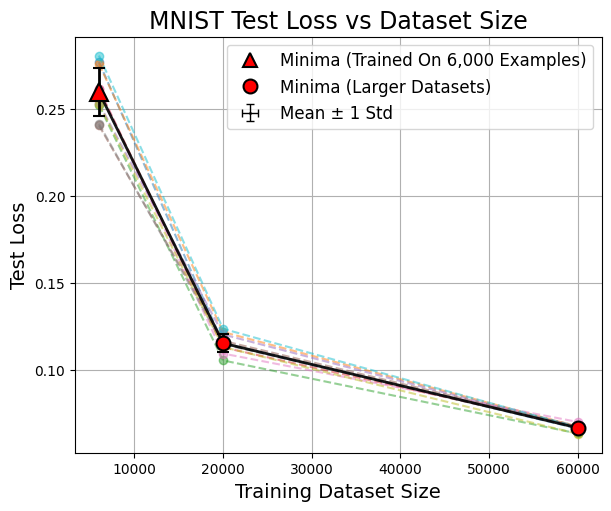

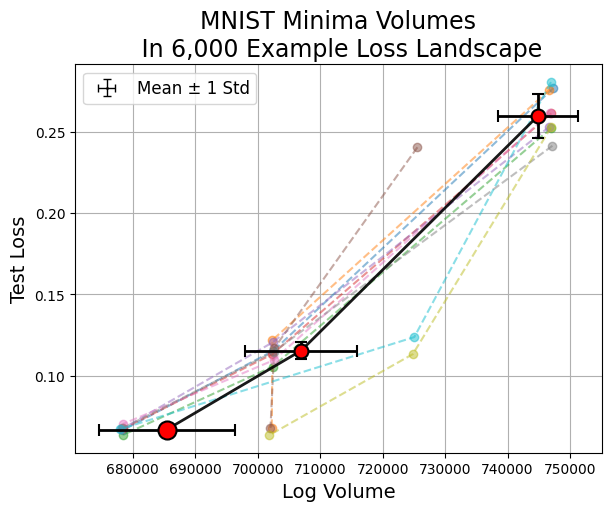

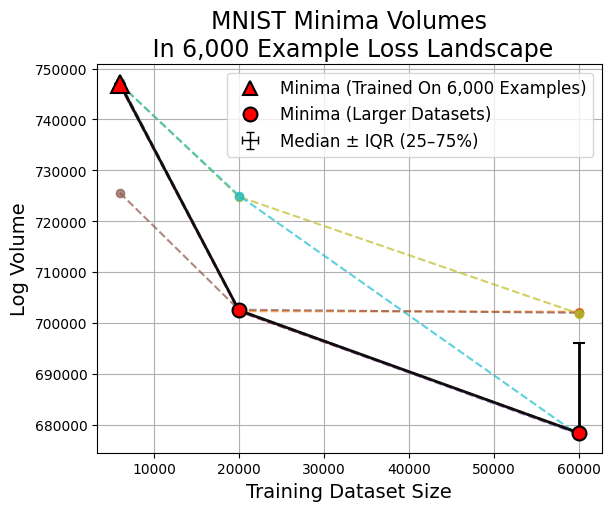

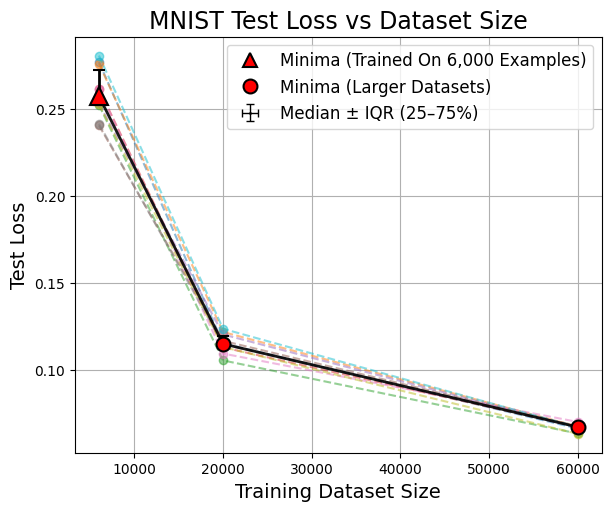

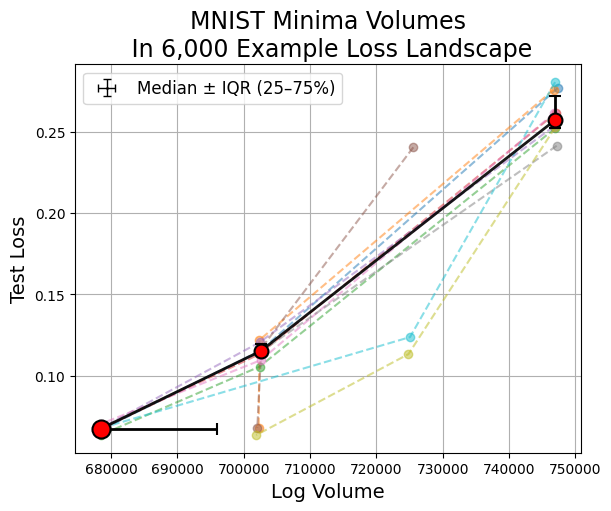


Processing data modification folder: data_59940
Saved data to analysis\data_59940\minima_data.npz


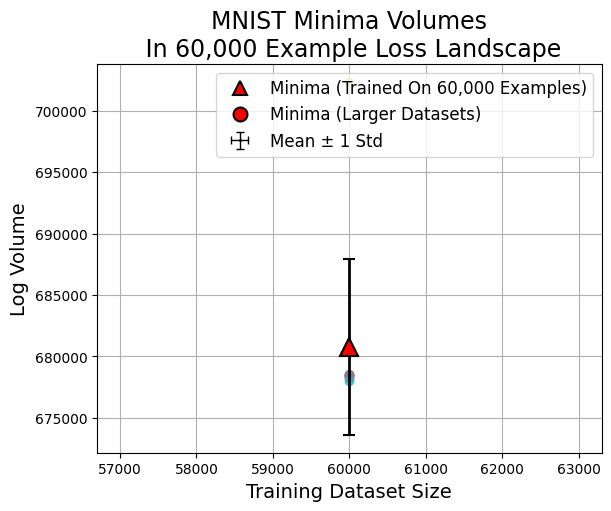

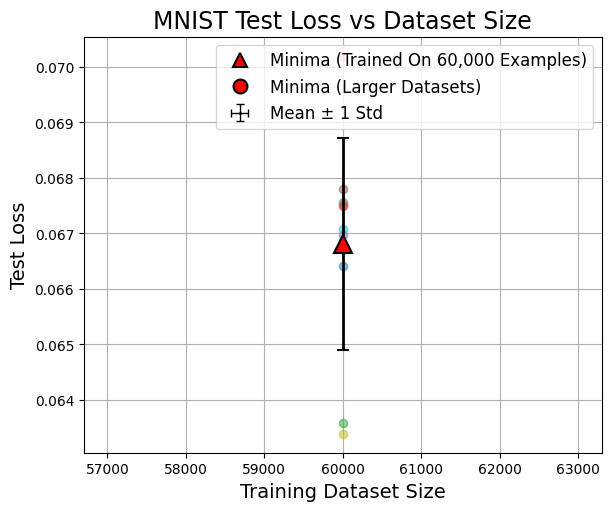

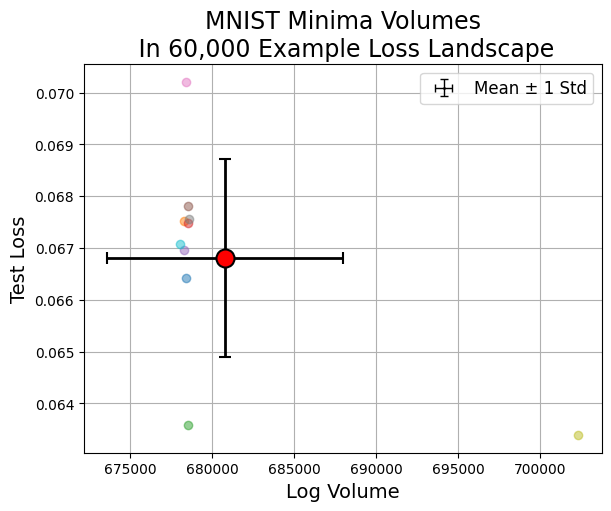

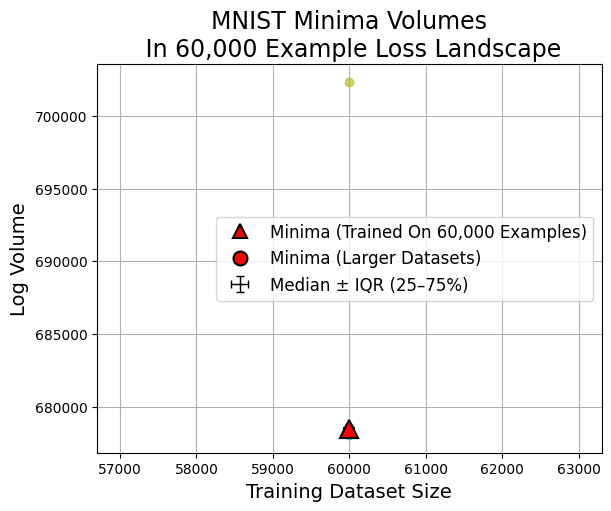

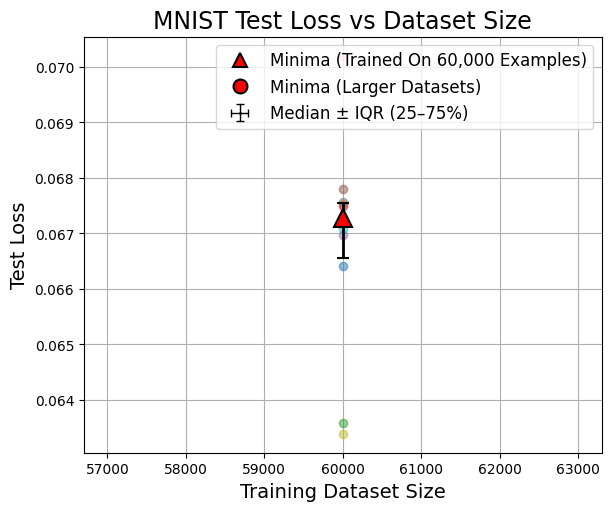

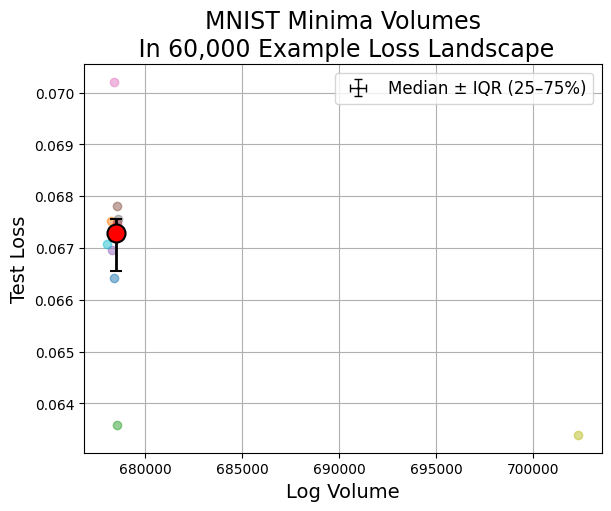

In [3]:
for data_modification in data_modifications:
    print(f"\nProcessing data modification folder: {data_modification}")

    # Create output folder for this data_modification
    save_dir = os.path.join(base_output_dir, data_modification)
    os.makedirs(save_dir, exist_ok=True)

    # Get axis labels and titles
    labels = fixed_landscape_minima_labels(data_modification, base_train_size)

    # Extract minima landscapes
    all_mdl, all_log_rn, all_test_loss = multiple_minima_fixed_landscape(
        experiment_folders, data_modification, loss_value #mdl is modification data level
    )
    number_of_minima = len(all_mdl[0]) # Not used currently

    all_mdl = np.array(all_mdl)
    all_log_rn = np.array(all_log_rn)
    all_test_loss = np.array(all_test_loss)
    
    # Print types and shapes
    #for name, var in [("all_mdl", all_mdl), ("all_log_rn", all_log_rn), ("all_test_loss", all_test_loss)]:
    #    print(f"{name}: type={type(var)}, shape={var.shape}")

    # Save the data using np.savez_compressed
    save_dict = {
        'all_mdl': all_mdl,
        'all_log_rn': all_log_rn,
        'all_test_loss': all_test_loss,
        'data_modification': np.array([data_modification], dtype=object),
        'base_train_size': np.array([base_train_size]),
        'base_shift': np.array([base_shift]),
        'labels': labels
    }
    
    output_path = save_dir
    filename = 'minima_data.npz'
    np.savez_compressed(os.path.join(output_path, filename), **save_dict)
    
    print(f"Saved data to {os.path.join(output_path, filename)}")
    
    # Central tendency runs: mean and median
    for ct, suffix in [("mean", "_avg"), ("median", "_median")]:
        for ranking in [False, True]:
            out_dir = save_dir if not ranking else os.path.join(save_dir, "ranks") #handles ranking
            os.makedirs(out_dir, exist_ok=True)

            # --- Data-level plots: loop through shaded + errorbar ---
            #for avg_style in ["shaded", "errorbar"]:
            #    style_suffix = "_shaded" if avg_style == "shaded" else "_errbar"
            style_suffix = "_errbar"
            avg_style = "errorbar"

            # --- Data level vs Log Volume ---
            plot_fixed_landscape_minima_pair(
                all_mdl, all_log_rn,
                xlabel=labels["xlabel"], ylabel="Log Volume",
                title=f"{problem_name} Minima Volumes\n In {base_train_size + int(data_modification.split("_")[1]):,} Example Loss Landscape",
                #labels["title_volume"],
                log_scale=data_level_log,
                ranking=ranking,
                alpha=0.7,
                output_dir=out_dir,
                filename="data_level_vs_log_volume" + suffix + style_suffix,
                show_plot=not ranking,
                plot_average=True,
                average_style=avg_style,
                central_tendency=ct,
                plot_x_error=(avg_style == "errorbar"),
                xlabel_size=14, ylabel_size=14, title_size=17,
                base_shift=base_shift,
                background_colors=None,#background_colors,     
                natural_minima_loc = 'first',
                natural_label=f"Minima (Trained On {base_train_size + int(data_modification.split("_")[1]):,} Examples)",
                other_label=other_label,               
                natural_marker="^",            
                other_marker="o",               
            )

            # --- Data level vs Test Loss ---
            plot_fixed_landscape_minima_pair(
                all_mdl, all_test_loss,
                xlabel=labels["xlabel"], ylabel="Test Loss",
                title=f"{problem_name} Test Loss vs Dataset Size",#labels["title_volume"],
                log_scale=False,
                ranking=ranking,
                alpha=0.5,
                output_dir=out_dir,
                filename="data_level_vs_test_loss" + suffix + style_suffix,
                show_plot=not ranking,
                plot_average=True,
                average_style=avg_style,
                central_tendency=ct,
                plot_x_error=(avg_style == "errorbar"),
                xlabel_size=14, ylabel_size=14, title_size=17,
                base_shift=base_shift,
                background_colors=None,#background_colors,     
                natural_minima_loc = 'first',
                natural_label=f"Minima (Trained On {base_train_size + int(data_modification.split("_")[1]):,} Examples)", 
                other_label=other_label,               
                natural_marker="^",            
                other_marker="o",               
            )

            # --- Log Volume vs Test Loss ---
            # Only error bar version (no shaded version)
            plot_fixed_landscape_minima_pair(
                all_log_rn, all_test_loss,
                xlabel="Log Volume", ylabel="Test Loss",
                title=f"{problem_name} Minima Volumes\n In {base_train_size + int(data_modification.split("_")[1]):,} Example Loss Landscape",
                #labels["title_volume"],
                log_scale=False,
                ranking=ranking,
                alpha=0.5,
                output_dir=out_dir,
                filename="log_volume_vs_test_loss" + suffix + "_errbar",
                show_plot=not ranking,
                plot_average=True,
                average_style="errorbar",
                central_tendency=ct,
                plot_x_error=True,  # allow x-error bars
                xlabel_size=14, ylabel_size=14, title_size=17,
                background_colors=None,#background_colors,              
                #natural_minima_loc = 'last',
                #natural_label=f"Minima (Trained On {base_train_size + int(data_modification.split("_")[1]):,} Examples)", 
                #other_label=other_label,               
                #natural_marker="^",            
                other_marker="o",               
            )

# Aggregrate Test Accuracy

Test accuracy vs dataset size across all plots.

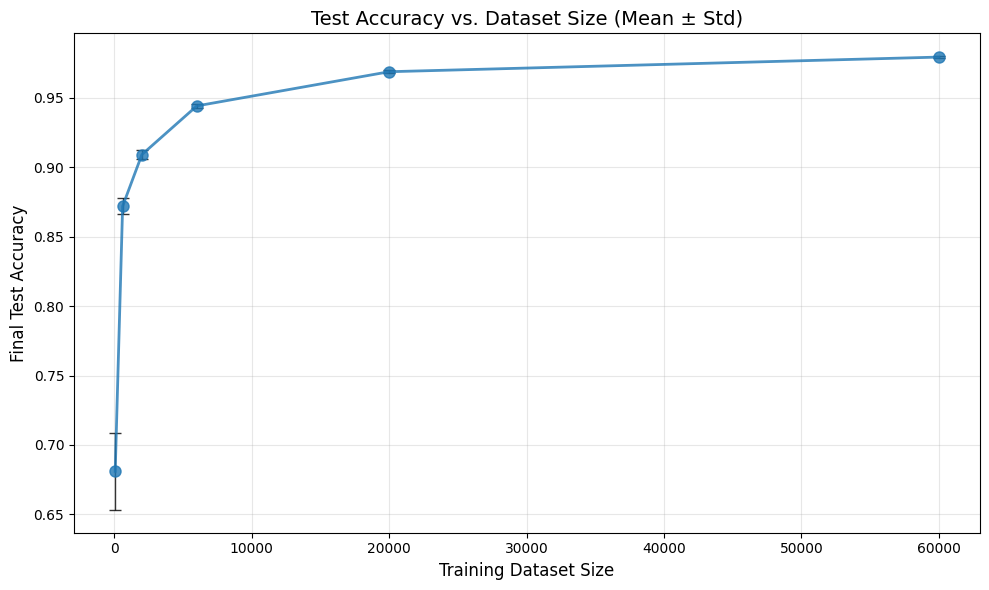

✅ Plot saved to analysis\test_acc_plot.png
✅ Aggregated data saved to analysis\test_acc.npz


In [4]:
missing_folders = [folder for folder in experiment_folders
                   if not os.path.exists(os.path.join(folder, "test_accuracies.npz"))]

if missing_folders:
    print(f"⚠️ Skipping aggregation — missing test_accuracies.npz in: {missing_folders}")
else:
    # ---------- Step 2: Load all data ----------
    all_dataset_sizes = []
    all_accuracies = []

    for folder in experiment_folders:
        file_path = os.path.join(folder, "test_accuracies.npz")
        data = np.load(file_path)
        all_dataset_sizes.extend(data["dataset_sizes"])
        all_accuracies.extend(data["final_test_accuracies"])

    all_dataset_sizes = np.array(all_dataset_sizes)
    all_accuracies = np.array(all_accuracies)

    # ---------- Step 3: Group by dataset size ----------
    grouped_data = defaultdict(list)
    for size, acc in zip(all_dataset_sizes, all_accuracies):
        grouped_data[size].append(acc)

    sorted_sizes = np.array(sorted(grouped_data.keys()))
    mean_accs = np.array([np.mean(grouped_data[size]) for size in sorted_sizes])
    std_accs = np.array([np.std(grouped_data[size]) for size in sorted_sizes])

    # ---------- Step 4: Plot with error bars ----------
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        sorted_sizes, mean_accs, yerr=std_accs,
        fmt='o-', capsize=4, linewidth=2, markersize=8,
        color='tab:blue', ecolor='black', elinewidth=1, alpha=0.8
    )

    plt.xlabel("Training Dataset Size", fontsize=12)
    plt.ylabel("Final Test Accuracy", fontsize=12)
    plt.title("Test Accuracy vs. Dataset Size (Mean ± Std)", fontsize=14)
    plt.grid(True, alpha=0.3)
    #plt.ylim((0.5, 1.0))
    plt.tight_layout()

    os.makedirs(base_output_dir, exist_ok=True)
    plot_path = os.path.join(base_output_dir, "test_acc_plot.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()
    plt.close()

    print(f"✅ Plot saved to {plot_path}")

    # ---------- Step 5: Save combined data ----------
    save_path = os.path.join(base_output_dir, "test_acc.npz")
    np.savez(
        save_path,
        dataset_sizes=sorted_sizes,
        mean_accuracies=mean_accs,
        std_accuracies=std_accs,
        all_dataset_sizes=all_dataset_sizes,
        all_accuracies=all_accuracies
    )
    print(f"✅ Aggregated data saved to {save_path}")

# Comparisons Across Loss Landscapes



Here, we track the performance of all models across all loss landscapes.

Collected results for 10 experiments
Collected results for 10 experiments
Collected results for 10 experiments
Collected results for 10 experiments
Collected results for 10 experiments
Collected results for 10 experiments
Model_0: first exceedance at index 68 (value=0.10856712609529495, threshold=0.1)
Appended cutoff for model_0_data_10 | target=0, cutoff_idx=68
Model_0: first exceedance at index 62 (value=0.20314551889896393, threshold=0.1)
Appended cutoff for model_1_data_11 | target=0, cutoff_idx=62
Model_0: first exceedance at index 68 (value=0.12642623484134674, threshold=0.1)
Appended cutoff for model_2_data_12 | target=0, cutoff_idx=68
Model_0: first exceedance at index 68 (value=0.19174586236476898, threshold=0.1)
Appended cutoff for model_3_data_13 | target=0, cutoff_idx=68
Model_0: first exceedance at index 64 (value=0.13705985248088837, threshold=0.1)
Appended cutoff for model_4_data_14 | target=0, cutoff_idx=64
Model_0: first exceedance at index 63 (value=0.1062258258461952

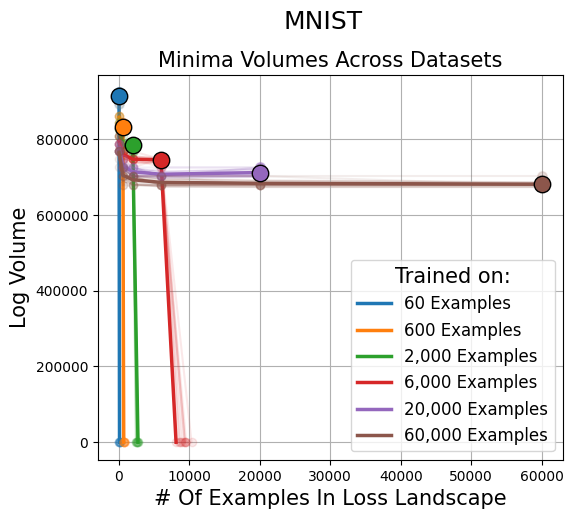

In [5]:
# For the poisoning experiments, this plot has no meaning

labels = varying_landscape_minima_labels(
    data_modification_folder=data_modifications[0], # Random choice to grab datatype from
    base_train_size=base_train_size,
)

results_dict = model_volume_across_targets(
    target_model_data_levels=model_data_sizes,
    loss_value=loss_value,
    experiment_folders=experiment_folders
)
results_with_cutoff = append_cutoff_points(results_dict, threshold=loss_value, base_dir=".")
save_results_dict_npz(results_with_cutoff, "analysis/volumes_across_datasets.npz")

found_minima_vol, found_minima_dataset = plot_minima_volume_vs_data_level(
    results_dict = results_with_cutoff,
    data_type=labels["data_type"],        
    base_train_size=base_train_size, 
    xlabel=labels["xlabel"],
    ylabel="Log Volume",
    suptitle=f"{problem_name}",
    title=f"Minima Volumes Across Datasets",
    log_scale = data_level_log,
    alpha=0.1,
    plot_average=True,
    output_dir=base_output_dir, filename="log_volumes_vs_data_levels",
    xlabel_size=15, ylabel_size=15, title_size=15, suptitle_size=18,
)

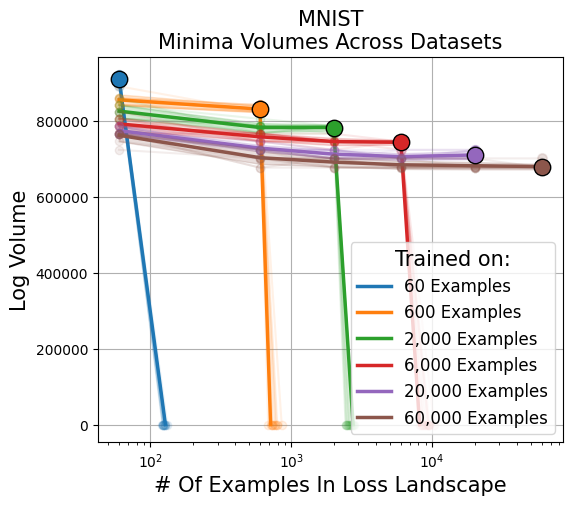

In [6]:
_, _, = plot_minima_volume_vs_data_level(
    results_dict = results_with_cutoff,
    data_type=labels["data_type"],          
    base_train_size=base_train_size, 
    xlabel=labels["xlabel"],
    ylabel="Log Volume",
    #suptitle=f"{problem_name}",
    title=f"{problem_name}\nMinima Volumes Across Datasets",
    log_scale = True,
    alpha=0.1,
    plot_average=True,
    output_dir=base_output_dir, filename="log_volumes_vs_data_levels_log",
    xlabel_size=15, ylabel_size=15, title_size=15, suptitle_size=18,
)

## Customized Plot

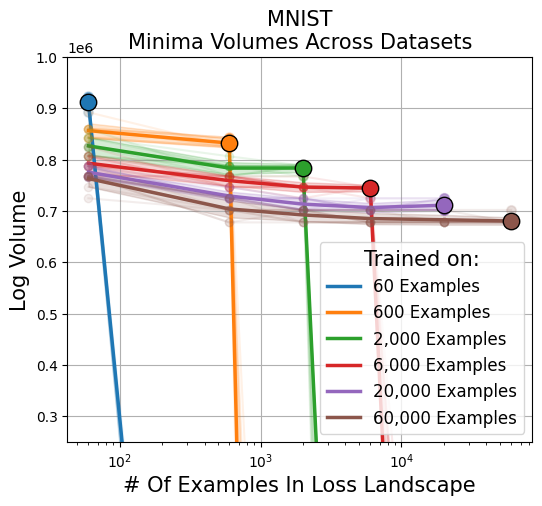

In [7]:
# We experiment a little with making customized graphs.

_, _, = plot_minima_volume_vs_data_level(
    results_dict = results_with_cutoff,
    data_type=labels["data_type"],          
    base_train_size=base_train_size, 
    xlabel=labels["xlabel"],
    ylabel="Log Volume",
    #suptitle=f"{problem_name}",
    title=f"{problem_name}\nMinima Volumes Across Datasets",
    log_scale = True,
    alpha=0.1,
    plot_average=True,
    output_dir=base_output_dir, filename="log_volumes_vs_data_levels_log_custom",
    xlabel_size=15, ylabel_size=15, title_size=15, suptitle_size=18,
    ylim = (250000, 1000000)
)

Fitting to y = a * log(x) + log(k) 
Exponent a = -34021.6084
Log k = 1048155.3822
y = -34021.6084 × log(x) + 1048155.3822
The exponent divided by the number of parameters is  -0.1446829134462225


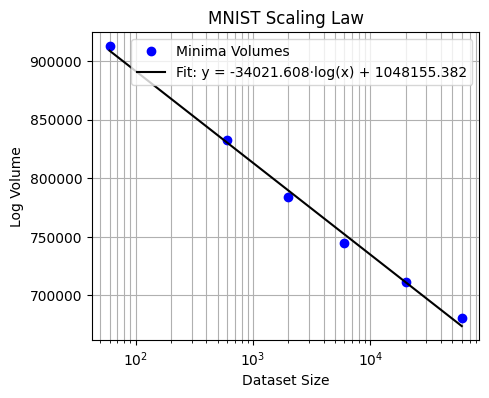

Figure saved to: analysis\scaling.png


In [8]:
# Convert to numpy arrays
x = np.array(found_minima_vol)
y = np.array(found_minima_dataset)

# Fit a linear relationship: y = n * log(x) + log(k)
coefficients = np.polyfit(np.log(x), y, 1)

# Extract the exponent n and constant log(k)
exponent = coefficients[0]  # This is your exponent!
log_k = coefficients[1]  # log of the constant

print(f"Fitting to y = a * log(x) + log(k) ")
print(f"Exponent a = {exponent:.4f}")
print(f"Log k = {log_k:.4f}")
#print(f"Power law relationship: z = {k:.4f} × x^{n:.4f}")
print(f"y = {exponent:.4f} × log(x) + {log_k:.4f}")

print("The exponent divided by the number of parameters is ", exponent/num_params)

# Create the fit line for plotting
x_fit = np.linspace(min(x), max(x), 100)
y_fit = exponent * np.log(x_fit) + log_k

# Plot
plt.figure(figsize=(5, 4))
plt.plot(x, y, 'bo', label="Minima Volumes")
plt.plot(x_fit, y_fit, 'k-', label=f'Fit: y = {exponent:.3f}·log(x) + {log_k:.3f}')
#plt.plot(xs, a*xs + b, '--', label=f"Fit: y = {np.exp(b):.2f} * x^{a:.2f}")
#plt.loglog(xs, fit_line, '--', label=f"Fit: y = {np.exp(b):.2f} * x^{a:.2f}")
plt.xscale("log")
plt.xlabel("Dataset Size")
plt.ylabel("Log Volume")
plt.title(f"{problem_name} Scaling Law")
plt.legend()
plt.grid(True, which="both")
output_path = os.path.join(base_output_dir, "scaling.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory

print(f"Figure saved to: {output_path}")